In [334]:
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from matplotlib import pyplot
%matplotlib inline  
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from darts import TimeSeries

In [335]:
carss = pd.read_csv("monthly-car-sales.csv")
carss.head()


,Month,Sales
0,1960-01,6550
1,1960-02,8728
2,1960-03,12026
3,1960-04,14395
4,1960-05,14587


In [336]:
scaler = MinMaxScaler()
scaler.fit(carss[['Sales']])
carss['Sales'] = scaler.transform(carss[['Sales']])

In [337]:
cars = TimeSeries.from_dataframe(carss, "Month", "Sales")
print(cars)

<TimeSeries (DataArray) (Month: 108, component: 1, sample: 1)>
array([[[0.04783011]],

       [[0.15391359]],

       [[0.31454873]],

       [[0.42993522]],

       [[0.43928693]],

       [[0.40051629]],

       [[0.19141786]],

       [[0.13068043]],

       [[0.07213482]],

       [[0.19370708]],

...

       [[0.70970727]],

       [[0.78695631]],

       [[1.        ]],

       [[0.75573523]],

       [[0.60669232]],

       [[0.54327602]],

       [[0.42944815]],

       [[0.76830159]],

       [[0.56558375]],

       [[0.43879986]]])
Coordinates:
  * Month      (Month) datetime64[ns] 1960-01-01 1960-02-01 ... 1968-12-01
  * component  (component) object 'Sales'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None


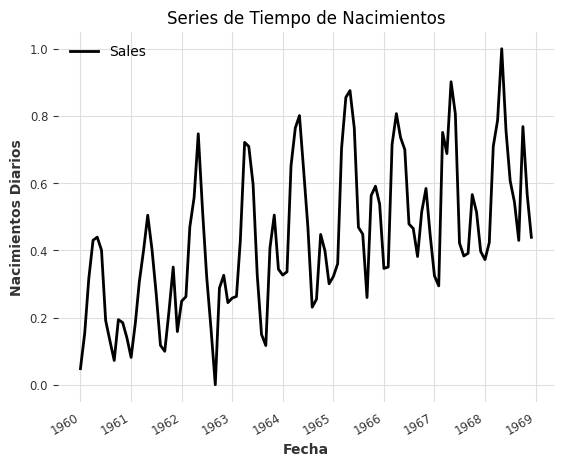

In [338]:
fig, ax = plt.subplots()
cars.plot(ax=ax)

ax.set_title("Series de Tiempo de Nacimientos")
ax.set_xlabel("Fecha")
ax.set_ylabel("Nacimientos Diarios")
plt.show()

En esta serie de Tiempo, de tiene estacionalidad y también se tiene tendiendica, ya que se ve que esta creciendo entre más tiempo pasa, por las ventas. También se ve la estacionalidad, que se ve durante los años, a princpios hay un gran pico, y cuando hay un gran pico negativo cuando esta a mediadios y finales del año. 

In [339]:
from darts.models import MovingAverageFilter, NaiveMean
from darts.metrics import rmse, mae, mape
from darts.models import NaiveMovingAverage, NaiveMean
from darts.metrics import rmse, mae, mape
window_size = 12  # Adjust the window size as needed
moving_avg = MovingAverageFilter(window=window_size)
carros = moving_avg.filter(cars)


In [340]:
rmse_score = rmse(cars, carros)
mae_score = mae(cars, carros)
print(f'RMSE: {rmse_score:.2f}')
print(f'MAE: {mae_score:.2f}')

RMSE: 0.18
MAE: 0.15


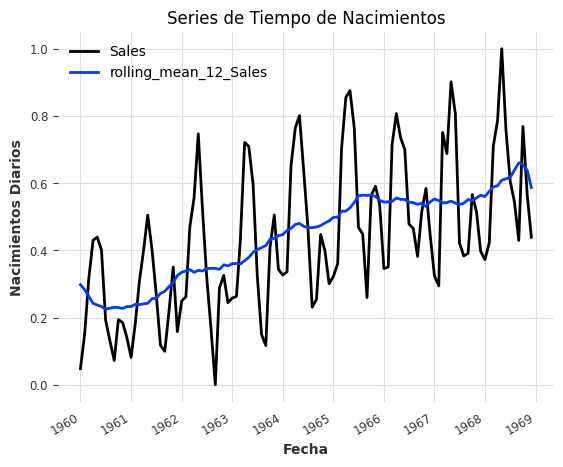

In [341]:
fig, ax = plt.subplots()
cars.plot(ax=ax)
carros.plot(ax=ax)

ax.set_title("Series de Tiempo de Nacimientos")
ax.set_xlabel("Fecha")
ax.set_ylabel("Nacimientos Diarios")
plt.show()

In [342]:
# Convert the "Year-Month" column to datetime format
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
carss['Month'] = pd.to_datetime(carss['Month'])

# Set the "Year-Month" column as the DataFrame index
carss.set_index('Month', inplace=True)
train_size = int(len(carss) * 0.8)
train_data, test_data = carss[:train_size], carss[train_size:]

In [343]:
p, d, q = 1, 1, 1  # Non-seasonal components
P, D, Q, s = 1, 1, 1, 12  # Seasonal components (assuming monthly data)

sarima_model = sm.tsa.SARIMAX(train_data, order=(p, d, q), seasonal_order=(P, D, Q, s))
sarima_results = sarima_model.fit()
predictions = sarima_results.get_forecast(steps=len(test_data))
predicted_mean = predictions.predicted_mean
confidence_intervals = predictions.conf_int()

c:\Users\rober\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\rober\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


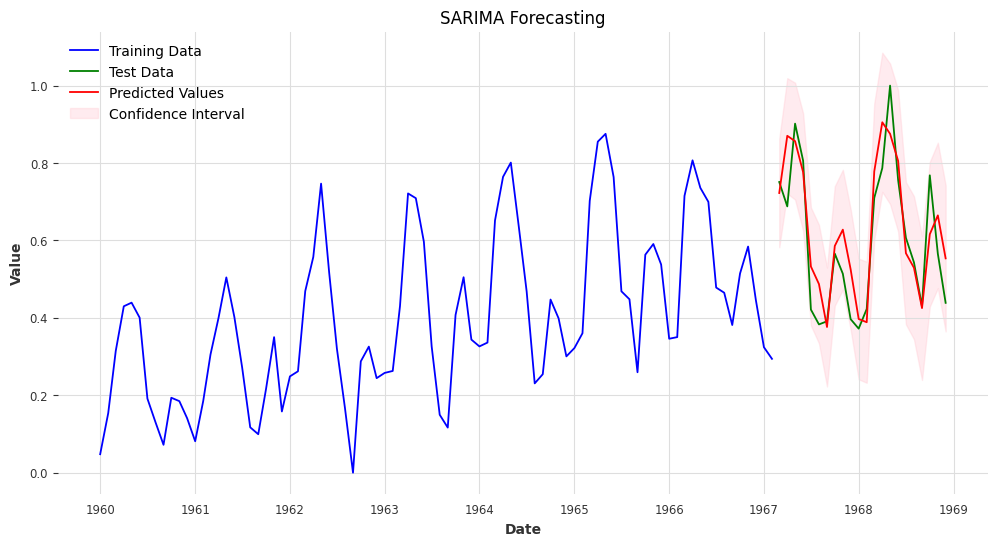

In [344]:
plt.figure(figsize=(12, 6))
plt.plot(train_data, label='Training Data', color='blue')
plt.plot(test_data, label='Test Data', color='green')
plt.plot(predicted_mean, label='Predicted Values', color='red')
plt.fill_between(confidence_intervals.index, confidence_intervals.iloc[:, 0], confidence_intervals.iloc[:, 1], color='pink', alpha=0.3, label='Confidence Interval')
plt.legend()
plt.title('SARIMA Forecasting')
plt.xlabel('Date')
plt.ylabel('Value')
plt.show()

In [345]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test_data, predicted_mean))

# Calculate MAE
mae = mean_absolute_error(test_data, predicted_mean)
print(f'RMSE: {rmse:.2f}')
print(f'MAE: {mae:.2f}')

RMSE: 0.09
MAE: 0.07


<TimeSeries (DataArray) (Month: 22, component: 1, sample: 1)>
array([[[0.6448356 ]],

       [[0.7800755 ]],

       [[0.8195794 ]],

       [[0.70561288]],

       [[0.49290374]],

       [[0.37631824]],

       [[0.30134367]],

       [[0.50794558]],

       [[0.55221835]],

       [[0.44252084]],

...

       [[0.68858062]],

       [[0.82382051]],

       [[0.86332442]],

       [[0.7493579 ]],

       [[0.53664876]],

       [[0.42006325]],

       [[0.34508869]],

       [[0.5516906 ]],

       [[0.59596336]],

       [[0.48626586]]])
Coordinates:
  * Month      (Month) datetime64[ns] 1967-03-01 1967-04-01 ... 1968-12-01
  * component  (component) object 'Sales'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None


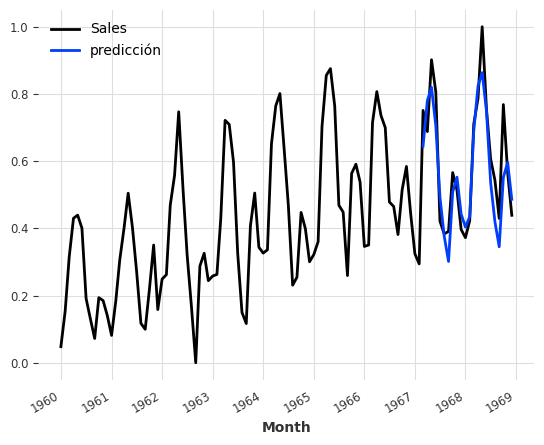

In [346]:
from darts.models import ExponentialSmoothing
train_size = int(len(cars) * 0.8)
train, test = cars[:train_size], cars[train_size:]
entreno, validacion = cars[:train_size], cars[train_size:]
model = ExponentialSmoothing()
model.fit(train)
cars.plot()
predictions = model.predict(len(test))
predictions.plot(label = "predicción")
plt.legend()
print(predictions)


In [347]:
from darts.metrics import rmse, mae
rmse_score = rmse(test, predictions)
mae_score = mae(test, predictions)
print(f'RMSE: {rmse_score:.2f}')
print(f'MAE: {mae_score:.2f}')

RMSE: 0.08
MAE: 0.07


18:14:12 - cmdstanpy - INFO - Chain [1] start processing
18:14:13 - cmdstanpy - INFO - Chain [1] done processing


<TimeSeries (DataArray) (Month: 22, component: 1, sample: 1)>
array([[[0.67956607]],

       [[0.88852873]],

       [[0.93173769]],

       [[0.81219989]],

       [[0.565057  ]],

       [[0.44641549]],

       [[0.3337886 ]],

       [[0.59378124]],

       [[0.68817845]],

       [[0.52687389]],

...

       [[0.81682614]],

       [[0.89615062]],

       [[0.93146824]],

       [[0.8203383 ]],

       [[0.63242787]],

       [[0.51676353]],

       [[0.46988829]],

       [[0.63639166]],

       [[0.64122707]],

       [[0.56854844]]])
Coordinates:
  * Month      (Month) datetime64[ns] 1967-03-01 1967-04-01 ... 1968-12-01
  * component  (component) object 'Sales'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None


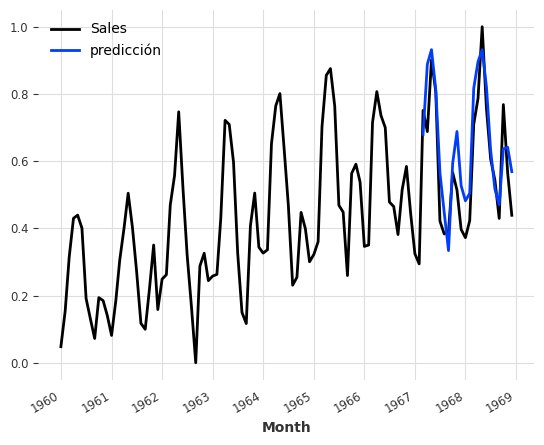

In [348]:
from darts.models.forecasting.prophet_model import Prophet
model = Prophet()
train_size = int(len(cars) * 0.8)
train, test = cars[:train_size], cars[train_size:]
entreno, validacion = cars[:train_size], cars[train_size:]
model.fit(train)
cars.plot()
predictions = model.predict(len(test))
predictions.plot(label = "predicción")
plt.legend()
print(predictions)

In [349]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test_data, predicted_mean))

# Calculate MAE
mae = mean_absolute_error(test_data, predicted_mean)
print(f'RMSE: {rmse:.2f}')
print(f'MAE: {mae:.2f}')

RMSE: 0.09
MAE: 0.07


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | RNN              | 700   
4 | V             | Linear           | 26    
---------------------------------------------------
726       Trainable params
0         Non-trainable params
726       Total params
0.003     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=75` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

<TimeSeries (DataArray) (Month: 22, component: 1, sample: 1)>
array([[[0.51879375]],

       [[0.74131925]],

       [[0.77853818]],

       [[0.63742784]],

       [[0.42699079]],

       [[0.29791661]],

       [[0.29228336]],

       [[0.4622088 ]],

       [[0.5451178 ]],

       [[0.39944106]],

...

       [[0.56124928]],

       [[0.77768031]],

       [[0.79750854]],

       [[0.6439077 ]],

       [[0.41019865]],

       [[0.24512283]],

       [[0.23750491]],

       [[0.44299456]],

       [[0.5338196 ]],

       [[0.3917561 ]]])
Coordinates:
  * Month      (Month) datetime64[ns] 1967-03-01 1967-04-01 ... 1968-12-01
  * component  (component) object 'Sales'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None


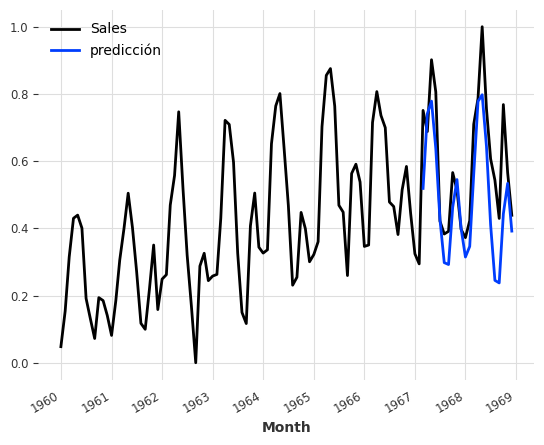

In [350]:
from darts.models import RNNModel
train_size = int(len(cars) * 0.8)
train, test = cars[:train_size], cars[train_size:]
entreno, validacion = cars[:train_size], cars[train_size:]
model = RNNModel(input_chunk_length=32, n_epochs=75, batch_size=4, random_state=2)
model.fit(train)
cars.plot()
predictions = model.predict(len(test))
predictions.plot(label = "predicción")
plt.legend()
print(predictions)

In [351]:
from darts.metrics import rmse, mae
rmse_score = rmse(test, predictions)
mae_score = mae(test, predictions)
print(f'RMSE: {rmse_score:.2f}')
print(f'MAE: {mae_score:.2f}')

RMSE: 0.15
MAE: 0.12


En este caso, es mucho mejor utilizar el Exponential Smoothing, con el menor RMSE y MAE siendo de 0.08 y 0.07 respectivamente. 